# **Week 4 assignment**

The project "Extracting the Kaggle dataset - nlp-getting-started'" is done as a part of week 4 assignment. The project involves analyzing tweets to find if a given tweet is a disater or not.  The regular NLP programs are good for analyzing textual data but they lack context. Using RNN that retains context,  Long Short-Term Memory Networks (LSTM) are a special form of RNNs are especially powerful when it comes to finding the right features when the chain of input-chunks becomes longer as in our tweets.

After performing some Exploratory Data Analysis like checking number of tweets, count of disaster and non-disaster tweets, spread of tweets by location, I attempted to clean the dataset by removing empty values, preprocessing the text to remove URLs, stemming, lowering all the texts and keeping only textual data.

Once the cleaning was performed, I converted every tweet into a vector. The method used is the One-Hot Encoding. Here, every word is represented by a vector of n binary sub-vectors, where n is the number of different chars in the alphabet (26 using the English alphabet). I initialized the vocabulary size to 20,000 to have a richer vocabulary to begin with. 
A 'pre' padding, equal to the length of largest size tweet, was applied to the encoded data to create equal size input for the model training.

Next, I created a training model that comprises of an Embedding layer which was initialized with chosen vocabulary size of 20,000, embedding_vector_features and input length. Next layer was LSTM that was initialized with chosen neurons. A dropout layer was added next. Finally a Dense layer with binary classification and Sigmoid activation to generate binary result was created.

With Adam optimizer, Binary CrossEntropy loss and Accuracy metrics the model was compiled and ran for various epochs using an EarlyStopping callback.

This allowed me to obtain an accuracy of 76%. This result was obtained after tweaking various hyperparameters with different values ex - embedding_vector_features values, input neurons for LSTM layer, Adam learning rates, and dropout percentages.

Finally the model was run against the test dataset and a result was generated that was combined with the tweet to submit the output.

In [1]:
#import libraries & packages
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers  import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2024-06-17 06:01:47.456698: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 06:01:47.456884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 06:01:47.630252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# load the training dataset
WORKING_DIR = '/kaggle/input/nlp-getting-started'
df = pd.read_csv(WORKING_DIR + "/train.csv")
test_df = pd.read_csv(WORKING_DIR + "/test.csv")

# **Exploratory Data Analysis**
- involves verifying the dataset dimension
- checking the columns
- inspecting some records using head()
- removing rows null columns values
- checking the number of records in training dataset that belongs to each class - a plot for verifying the lenght of tweets grouped by class
- a plot for grouping tweets by locations

Finally the data was preprocessed to only keep alphabets and remove URLs from each tweet

In [3]:
# retrieve the dataset dimensions
df.shape

(7613, 5)

In [4]:
# retrieve the columns
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [5]:
# inspect top 5 rows
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<Axes: ylabel='count'>

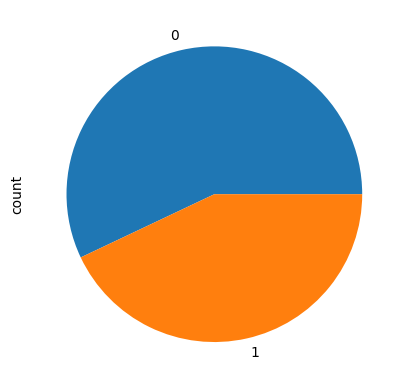

In [6]:
# draw chart to show split between disaster & non-disaster tweet in the training dataset
df['target'].value_counts(dropna=False).plot(kind="pie")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

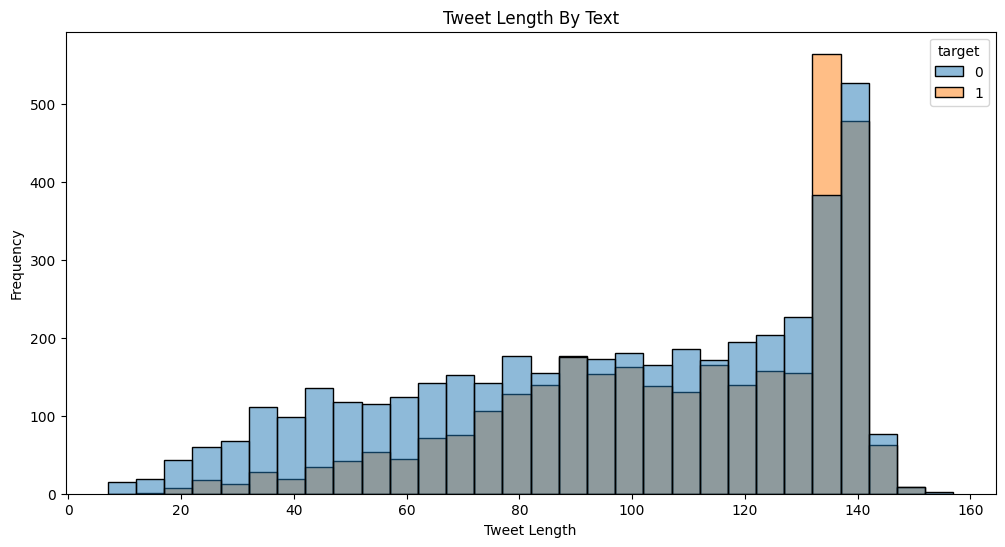

In [7]:
# Calculate the length of each tweet. 
df['length'] = df['text'].apply(len)

custom_palette = {0: "green", 1: "blue"}
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='length', hue='target', bins=30)
plt.title('Tweet Length By Text')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

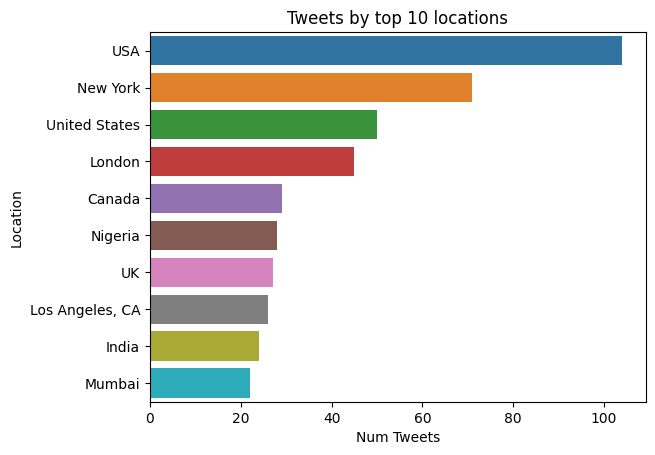

In [8]:
# Drar chart for top 10 tweets by locations.
top_locations = df['location'].value_counts().head(10)
sns.barplot( x=top_locations.values, y=top_locations.index)
plt.title('Tweets by top 10 locations')
plt.xlabel('Num Tweets')
plt.ylabel('Location')
plt.show()

In [9]:
# remove missing columns from text or target dataset
df = df.dropna(subset=['text', 'target'], thresh=1)
df.shape

(7613, 6)

In [10]:
# create feature and target datasets
X = df['text']
y = df['target']

In [11]:
# retrieve the feature and target dataset dimensions 
(X.shape,y.shape)

((7613,), (7613,))

In [12]:
# copy the feature into another dataset for processing
messages  = X.copy()

In [13]:
# download stopwords from nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


False

In [14]:
# routine for pre-processing
def preprocess_data(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '',text)     # Delete URL
    text = re.sub('[^a-zA-Z]',' ',text)
    return text

In [15]:
ps = PorterStemmer()
# routing for creating corpus. This function pre-processes each tweet and removes non-english words.
# creates an array of stems in a message and returns all the data as a corpus.
def create_corpus(data):
  corpus = []
  for i in range(0,len(data)):
    text = preprocess_data(data[i])
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    corpus.append(text)
  return corpus

In [16]:
# select the vocabulary size  
vocabulary_size = 20000

In [17]:
# the routine creates one hot encoding (dense matrix) from the input corpus.
def create_hotencoding(corpus):
  return [one_hot(word, vocabulary_size) for word in corpus]

In [18]:
# get the size of largest message in the input. 
# This allows us to create an embedding of the length that includes all the messages
def get_max_length_for_embedding(data):
  sentence_len = 0
  for words in data:
    sentence_len = max(sentence_len, len(words))
  return sentence_len

In [19]:
# preprocess and create a corpus from the tweets
corpus = create_corpus(messages)

In [20]:
# get max length used for creating embedding.
sentence_len = get_max_length_for_embedding(corpus)
print(sentence_len)

127


In [21]:
# create a pre paddding for tweets shorter than the max length tweet
embedded_docs = pad_sequences(create_hotencoding(corpus), padding='pre', maxlen=sentence_len)
print(embedded_docs[10])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0 17609 11495  8453 18120 11010 18058]


# **Model selection and training**

Selected a training model that comprises of an Embedding layer which was initialized with chosen 
- vocabulary size of 10,000, 20,000 words 
- *embedding_vector_features* with 100, 110, 120, 200, 300, 400 was selected. 
- *LSTM* was tested with 200, 250, 300 and 350 neurons. 
- A *Dropout layer* with 20, 25 and 30 percent dropout was added next. 
- Finally a *Dense layer* with *binary classification* and *Sigmoid* activation 

to generate binary result was created.

Between *Ada, Adagrad and Adam* optimizer, Adam resulted in the best output. Binary CrossEntropy loss and Accuracy metrics for the model was used.

Below is the model with the highest accuracy of validation result was selected.

In [22]:
embedding_vector_features = 120
lstm_neurons_count = 150
dropout_percent = 0.2
activation = 'sigmoid'
loss_fn = 'binary_crossentropy'


def create_model(evf, lstm_neurons_count, dropout_percent, activation, loss, metrics):
    model = Sequential()
    model.add(Embedding(vocabulary_size, evf))
    model.add(Dropout(dropout_percent))
    model.add(LSTM(lstm_neurons_count))
    model.add(Dropout(dropout_percent))
    model.add(Dense(1,activation=activation))
    model.compile(loss=loss, optimizer=Adam(1e-4),metrics =['accuracy'])
    print(model.summary())
    return model

model = create_model(embedding_vector_features, lstm_neurons_count, dropout_percent, activation,loss_fn,['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
# create np array of feature and target for it to work with tensorflow.
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [24]:
# validate the shape of final feature and target sets
X_final.shape, y_final.shape

((7613, 127), (7613,))

In [25]:
# create a callback to stop early that monitors losses.
callback = EarlyStopping(monitor='loss', patience=3)

In [26]:
# split the training dataset into train and validation set.
X_train, X_test,y_train,y_test = train_test_split(X_final, y_final, test_size=.2, random_state=69)

In [27]:
# fit the model
history = model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=12,batch_size=128,callbacks=[callback])

Epoch 1/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - accuracy: 0.5482 - loss: 0.6884 - val_accuracy: 0.5850 - val_loss: 0.6680
Epoch 2/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 363ms/step - accuracy: 0.5598 - loss: 0.6744 - val_accuracy: 0.5909 - val_loss: 0.6554
Epoch 3/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 353ms/step - accuracy: 0.6098 - loss: 0.6500 - val_accuracy: 0.6546 - val_loss: 0.6354
Epoch 4/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 358ms/step - accuracy: 0.6964 - loss: 0.6218 - val_accuracy: 0.7255 - val_loss: 0.5793
Epoch 5/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step - accuracy: 0.7729 - loss: 0.5341 - val_accuracy: 0.7623 - val_loss: 0.4886
Epoch 6/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 358ms/step - accuracy: 0.8229 - loss: 0.4147 - val_accuracy: 0.7932 - val_loss: 0.4535
Epoch 7/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - accuracy: 0.8554 - loss: 0.3544 - val_accuracy: 0.7971 - val_loss: 0.4535
Epoch 8/12
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 357ms/step - accuracy: 0.8717 - loss: 0.3142 - val_accu

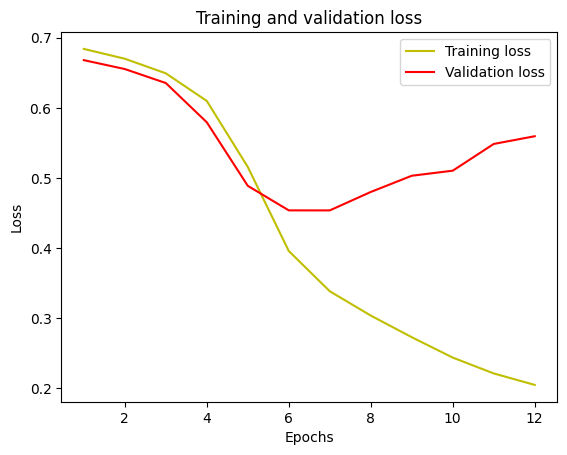

In [28]:
# create a chart for training and validation loss.
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# create prediction from the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


In [30]:
# generate confusion matrix to observe FP and FN
confusion_matrix(y_test,y_pred[:, 0])

array([[732, 159],
       [182, 450]])

In [31]:
# generate accuracy score
accuracy_score(y_pred, y_test)

0.7760998030203545

In [32]:
# inspect first 5 rows of the test set
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [33]:
# inspect the shape of test set
test_df.shape

(3263, 4)

In [34]:
# create corpus and embedding from test dataset and predict test result from the trained model
corpus = create_corpus(test_df['text'])
sentence_len = get_max_length_for_embedding(corpus)
embedded_docs = pad_sequences(create_hotencoding(corpus), padding='pre', maxlen=sentence_len)

print(embedded_docs)


X_final = np.array(embedded_docs)
result = (model.predict(X_final) > 0.5).astype("int32")

[[    0     0     0 ...  5290 17276 19066]
 [    0     0     0 ...  4867 13504 19908]
 [    0     0     0 ...  4569 14559 10069]
 ...
 [    0     0     0 ...  4623 18690  9462]
 [    0     0     0 ...  4222 14241 11988]
 [    0     0     0 ...  4627 17629 15274]]
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step


In [35]:
# result.shape
out = result.reshape(len(result),)
out

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [36]:
# validate 0s and 1s in the result 
ones = np.count_nonzero(result)
zeroes = len(result) - ones
(zeroes,ones)

(1927, 1336)

In [37]:
# generate a new dataset from the test result
df_result = pd.DataFrame({'id':test_df['id'], 'text':test_df['text'], 'target':out})

In [38]:
# inspect top 20 test tweets with target result
df_result.head(20)

,id,text,target
0,0,Just happened a terrible car crash,1
1,2,"Heard about #earthquake is different cities, s...",1
2,3,"there is a forest fire at spot pond, geese are...",1
3,9,Apocalypse lighting. #Spokane #wildfires,0
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1
5,12,We're shaking...It's an earthquake,0
6,21,They'd probably still show more life than Arse...,0
7,22,Hey! How are you?,0
8,27,What a nice hat?,0
9,29,Fuck off!,0


In [39]:
# inspect last 20 test tweets with target result
df_result.tail(20)

,id,text,target
3243,10796,'What manner of human being would parcel out a...,1
3244,10797,@Nathan26_RFC thought you said Saturday night ...,1
3245,10801,I just wanna ease your mind and make you feel ...,0
3246,10804,@yakubOObs think he deactivated because his no...,0
3247,10806,RT CNBC '3 words from Disney CEO Bob Iger wrec...,0
3248,10807,Smackdown tyme this should put me in a good mo...,0
3249,10816,@thrillhho jsyk I haven't stopped thinking abt...,0
3250,10820,@stighefootball Begovic has been garbage. He g...,0
3251,10828,Wrecked today got my hattrick ????,0
3252,10836,#Ebola #EbolaOutbreak Ebola Virus: Birmingham ...,1


In [40]:
# save the result for submission
df_result.to_csv('/kaggle/working/submission.csv',columns=['id', 'target'])

# **Summary**

The model was trained with 7000+ tweets using Recurrent Neural Network - LSTM with various hyperparameters and tuning was performed. 
It was observed that after 5 epochs the validation loss is continuosly increasing which means that there is a good scope for more tuning.
The resulting accuracy was around 76%, which was used to generate test result classification. On inspecting the test results, it was found that good amount of tweets were classified correctly.